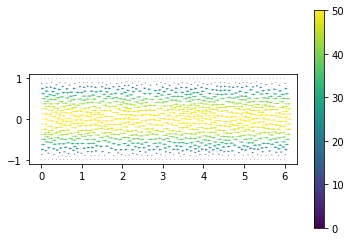

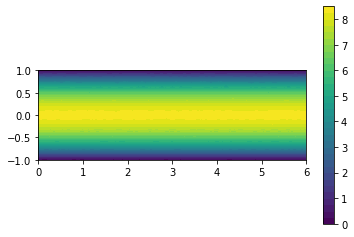

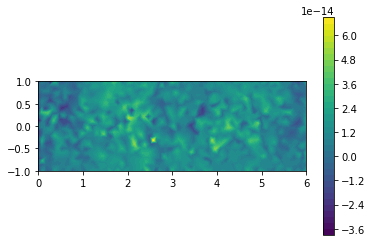

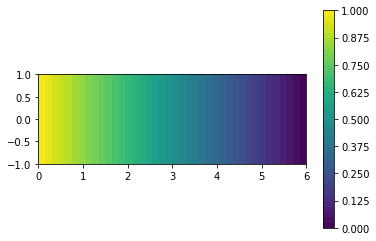

In [145]:
from dolfin import *
import mshr
import sympy as sym
N = 32
L = 6
f = Constant((0.0, 0.0))
domain = mshr.Rectangle(Point(0, -1), Point(L, 1))
mesh = mshr.generate_mesh(domain, N)

T = 10.0           # final time
num_steps = 500    # number of time steps
dt = T / num_steps # time step size
mu = 0.035             # kinematic viscosity
rho = 1            # density

epsilon = 0


g = Constant((-1.0, 0.0))
# Build function space
P2 = VectorElement("P", mesh.ufl_cell(), 2)
P1 = FiniteElement("P", mesh.ufl_cell(), 1)
TH = P2 * P1
W = FunctionSpace(mesh, TH)

x, y = sym.symbols('x[0], x[1]')  
G = -1/6
p_0 = 1
p_D = G * x + p_0 +y * 0
u_D = -G * (1 - y * y) / (2 * mu) + x * 0


u_D = sym.simplify(u_D)
u_D = Expression(sym.printing.ccode(u_D), degree=5)
p_D = sym.simplify(p_D)
p_D = Expression(sym.printing.ccode(p_D), degree=5)


inflow  = 'near(x[0], 0)'
outflow = 'near(x[0], 6)'
walls   = 'near(x[1], -1) || near(x[1], 1)'

# Define boundary conditions
bcu_noslip  = DirichletBC(W.sub(0), Constant((0, 0)), walls)
#bcp_inflow  =BC(W.sub(1), Constant(100), inflow)
#bcp_outflow = DirichletBC(W.sub(1), Constant(0), outflow)

bcs = [bcu_noslip]
# The bilinear and linear forms corresponding to the weak mixed
# formulation of the Stokes equations are defined as follows: ::

# Define variational problem
(u, p) = TrialFunctions(W)
(v, q) = TestFunctions(W)

a = (mu*inner(grad(u), grad(v)) + div(v)*p + mu*q*div(u) + epsilon/N/N/mu*inner(grad(q), grad(p)))*dx
L = inner(f, v)*dx - inner(g,v)*dx 

U = Function(W)
solve(a == L, U, bcs)

# Get sub-functions
u, p = U.split()

# Save solution in VTK format
ufile_pvd = File("velocity.pvd")
ufile_pvd << u
pfile_pvd = File("pressure.pvd")
pfile_pvd << p


import matplotlib.pyplot as plt
c = plot(u)
plt.colorbar(c)
plt.show()


u_D = project(u_D, FunctionSpace(mesh, "P", 4))
c2 = plot(u_D)
plt.colorbar(c2)
plt.show()

d = plot(p)
plt.colorbar(d)
plt.show()

p_D = project(p_D, FunctionSpace(mesh, "P", 4))
d2 = plot(p_D)
plt.colorbar(d2)
plt.show()

What flows in flows "out"
$$
\int_{\Omega} \nabla \cdot \mathbf{u}=\int_{\partial \Omega} \mathbf{u} \cdot \mathbf{n}=0
$$
the $\int_{\partial \Omega} \mathbf{u} \cdot \mathbf{n} = 0$ due to collinear vectors on the boundary. Let's chech the $\int_{\Omega} \nabla \cdot \mathbf{u}$

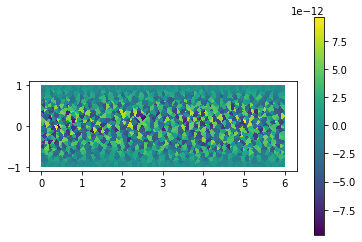

-9.446814803737369e-13


In [146]:
SpaceDG0 = FunctionSpace(mesh, 'DG', 0 )
divu = project(div(u),SpaceDG0)
d3 = plot(divu)
plt.colorbar(d3)
plt.show()
summ = assemble(divu*dx)
tol = 1e-14
class BoundaryX1(SubDomain):
        def inside(self, x, on_boundary):
            return on_boundary and near(x[0], 6, tol)
boundary_markers = MeshFunction('size_t', mesh, mesh.topology().dim() - 1) 
boundary_markers.set_all(9999)
bx1 = BoundaryX1()
bx1.mark(boundary_markers, 1)
#FS = VectorFunctionSpace(mesh, 'P', 4 )
#u_project = project(u, FS)
#u_p = project(u, SpaceDG0)
ds = Measure('ds', domain=mesh, subdomain_data=boundary_markers)
summ2 = assemble(u[0]*ds(1))

print(summ)